In [0]:
%matplotlib notebook

import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
import socket, getpass
import nntools as nt
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.python.keras.preprocessing import image as kp_image
from torch import optim
from torch.autograd import Variable

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Data Loader:

In [0]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [0]:
style_train = pd.read_csv('/datasets/ee285f-public/wikiart/Style/style_train.csv', header=None)
style_img = style_train[0].tolist() # list of jpg files of style images 
style_type = style_train[1].tolist() # list of numbers

In [0]:
class WikiartDataset(td.Dataset):
    def __init__(self, root_dir, mode="train", image_size=(512, 512)):
        super(WikiartDataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        self.images = style_img
        self.styles = style_type
        self.images_dir = os.path.join(root_dir)
    def __len__(self):
        return len(self.data)
    def __repr__(self):
        return "WikiartDataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, \
                                self.images[idx])
        img = Image.open(img_path).convert('RGB')
        transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
            ])
        x = transform(img)
        d = self.styles[idx]
        return x, d
    def number_of_classes(self):
        return len(set(self.styles))

In [0]:
image_root_dir='/datasets/ee285f-public/wikiart/wikiart/'
wikiart = WikiartDataset(image_root_dir)

In [0]:
#myimshow(wikiart[5][0]) # This image will be our content image in part 1

In [0]:
#myimshow(wikiart[114][0]) # This image will be our content image in part 1

# 1 Neural Style Transfer

# Feature Extraction

In [0]:
vgg = tv.models.vgg19_bn(pretrained=True).eval().to(device)
features = vgg.features
for param in vgg.parameters():
    param.requires_grad = False

In [0]:
def compute_mse(F,P):
    loss = nn.MSELoss()
    return loss(F, P)

In [0]:
#style_layers = [0,5,10,19,28] # works best.. 19 is batch, 21 is conv2d
#content_layer = 21

#style_layers = [1,6,11,20,29] # works worst
#content_layer = 22

#style_layers = [2,7,12,21,30] # works alright
#content_layer = 23


style_layers = [0,7,14,27,40]
content_layer = 27

optIm = torch.zeros(1,3, 512, 512).data.normal_(0, .5).view(3,512,512) # generated image

In [0]:
def compute_cont_loss(i,x):
    return compute_mse(vgg.features[:i](x.unsqueeze(0)),vgg.features[:i](p.unsqueeze(0)))

In [0]:
#Gram Matrix
def compute_style_loss(i,x):
    G = vgg.features[:i](x.unsqueeze(0))
    A = vgg.features[:i](a.unsqueeze(0))
    
    N = G.shape[1]
    M = G.shape[2]*G.shape[3]
    
    # The multiplication inside G.view() and A.view() is simply reshaping G and A to do mm
    G = torch.mm(G.view(G.shape[0]*G.shape[1],G.shape[2]*G.shape[3]), 
                 G.view(G.shape[0]*G.shape[1],G.shape[2]*G.shape[3]).t())
    A = torch.mm(A.view(A.shape[0]*A.shape[1],A.shape[2]*A.shape[3]), 
                 A.view(A.shape[0]*A.shape[1],A.shape[2]*A.shape[3]).t())
    
    return 1/(4*M)*compute_mse(G,A)
    #return 1/(4*(N**2)*(M**2))*compute_mse(G,A)

In [0]:
def evaluate_loss(x):
    loss_cont = 10*compute_cont_loss(content_layer,x)
    E = []
    #style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
    style_weights = [10,1,.1,.1,.1]
    style_weights = [.001,.05,.1,7,25]

    for i in range(len(style_layers)):    
        E.append(style_weights[i]*compute_style_loss(style_layers[i],x))
    loss = loss_cont +sum(E)
    return loss,loss_cont,sum(E)

In [0]:
def optimize(optIm,a,p,iterations=700):
    x = Variable(optIm.data.clone().to(device), requires_grad=True)
    optimizer = optim.LBFGS([x],max_iter=1);
    
    n_iter=[0]
    tot_loss_ar = []
    tot_loss_cont_ar = []
    tot_loss_style_ar = []
    fig = plt.figure(figsize=(8,8))

    while n_iter[0] <= iterations:
        if n_iter[0]%50 == 0:
            ax1=plt.subplot(2, 2, 1)
            ax1.set_title('Style Image')
            myimshow(a)
            ax1=plt.subplot(2, 2, 2)
            ax1.set_title('Content Image')
            myimshow(p)
            ax1=plt.subplot(2, 2, 3)
            ax1.set_title('Output Image')
            myimshow(x.detach())
            ax1=plt.subplot(2, 2, 4)
            ax1.set_title('Losses')

            line_one, = plt.plot(np.log10(tot_loss_ar), label='Total Loss')
            line_two, = plt.plot(np.log10(tot_loss_cont_ar), label='Cont. Loss')
            line_three, = plt.plot(np.log10(tot_loss_style_ar), label='Style Loss')

            plt.legend(handles=[line_one, line_two, line_three])
            plt.ylabel('loss (log10)')
            plt.tight_layout()
            fig.canvas.draw()
        def closure():
            optimizer.zero_grad()
            loss,loss_cont,E= evaluate_loss(x)
            tot_loss_ar.append(loss.detach())
            tot_loss_cont_ar.append(loss_cont.detach())
            tot_loss_style_ar.append(E.detach())


            loss.backward()
            n_iter[0]+=1

            return loss
        optimizer.step(closure)
    plt.close()

In [0]:
def getLandscapeDataset(path,image_size=(512,512)):
    transform = tv.transforms.Compose([
        tv.transforms.Resize(image_size,Image.LANCZOS),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])
    landscape_dataset = tv.datasets.ImageFolder(path,transform) #what I downloaded
    return landscape_dataset
testImages = getLandscapeDataset('Test_Images')

<IPython.core.display.Javascript object>


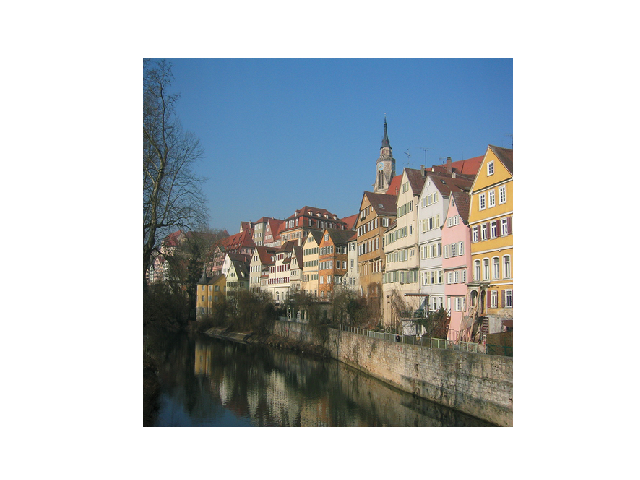

In [0]:
plt.figure()
myimshow(testImages[0][0])

<IPython.core.display.Javascript object>


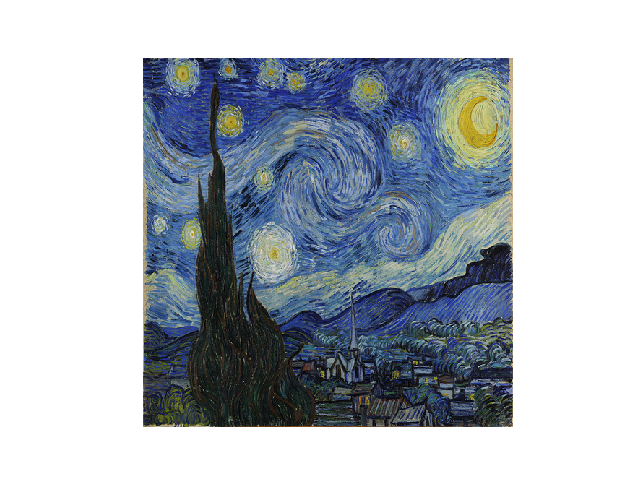

In [0]:
plt.figure()
myimshow(testImages[1][0])

<IPython.core.display.Javascript object>


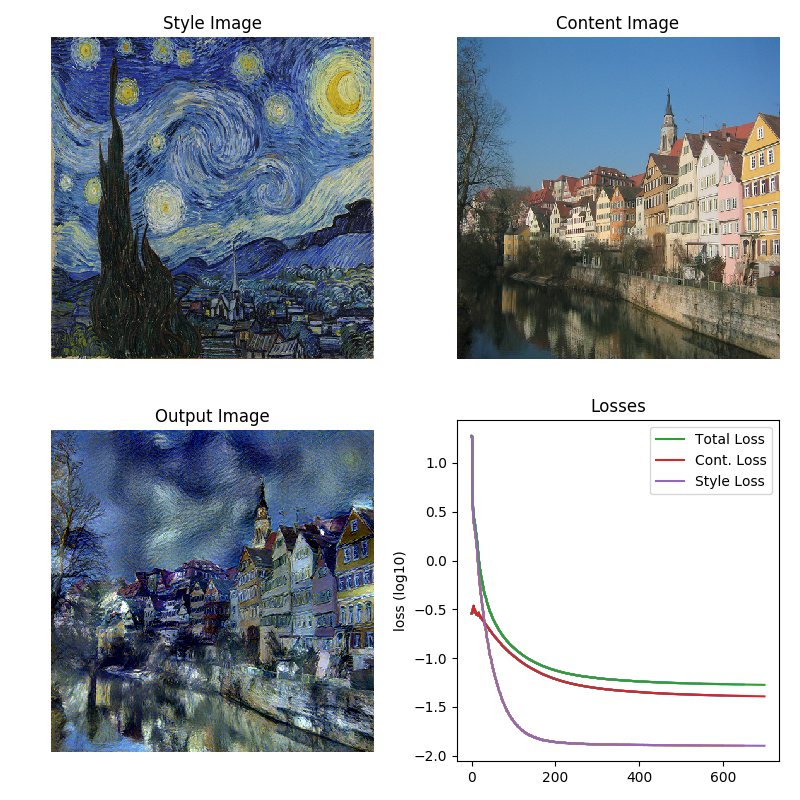

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [0]:
a = testImages[1][0].to(device)
p = testImages[0][0].to(device)
optIm = torch.zeros(1,3, 512, 512).data.normal_(0, .5).view(3,512,512) # generated image
optimize(optIm,a,p,700)

<IPython.core.display.Javascript object>


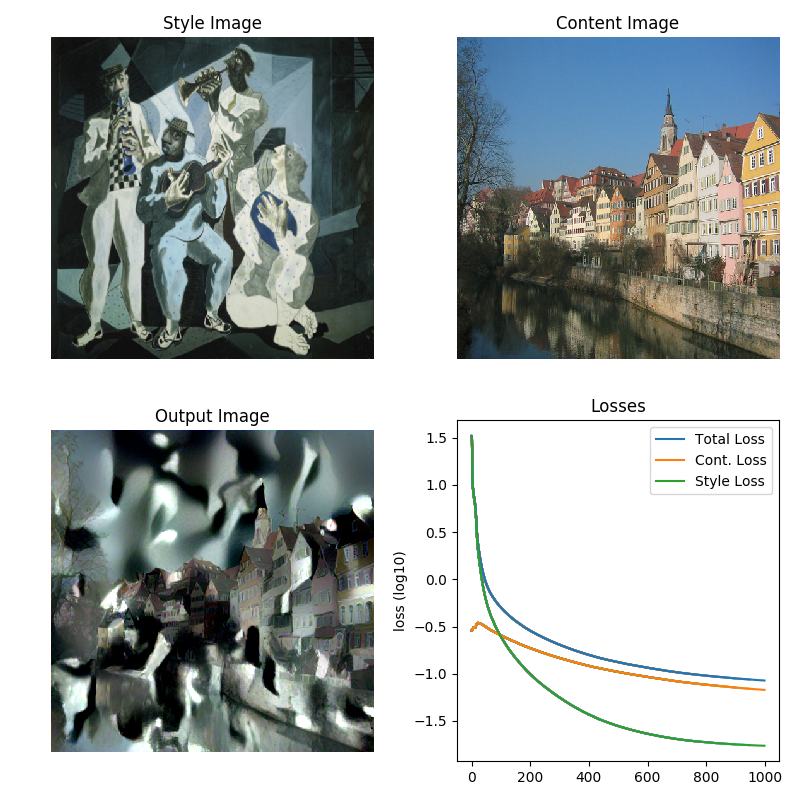

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [0]:
a = wikiart[5][0].to(device) # style image
p = testImages[0][0].to(device) # style image
optimize(optIm,a,p,1000)

<IPython.core.display.Javascript object>


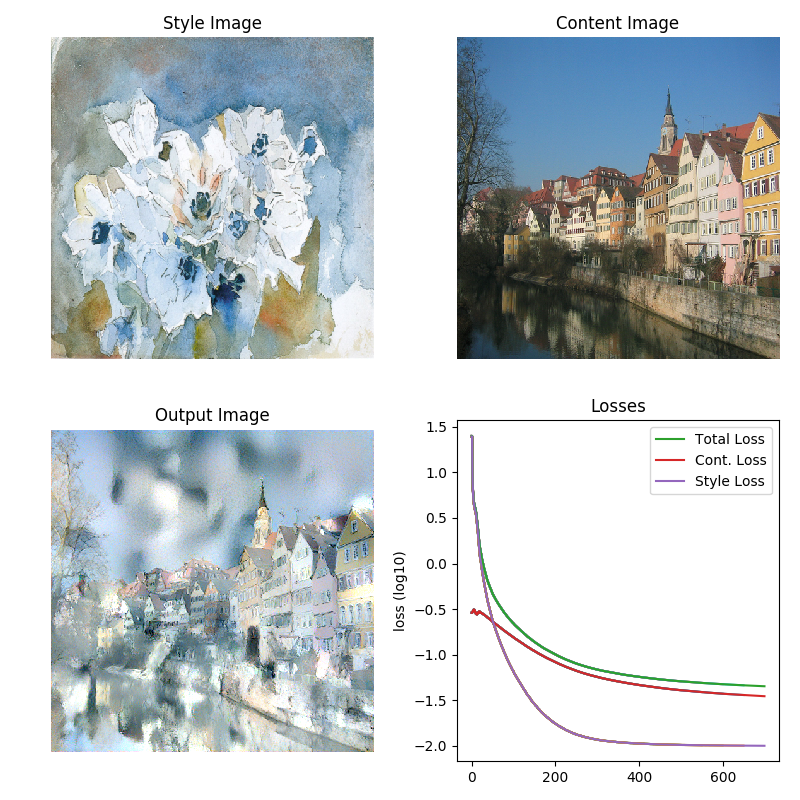

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [0]:
#105,123
a = wikiart[125][0].to(device) # style image
p = testImages[0][0].to(device) # style image
optimize(optIm,a,p,700)

<IPython.core.display.Javascript object>


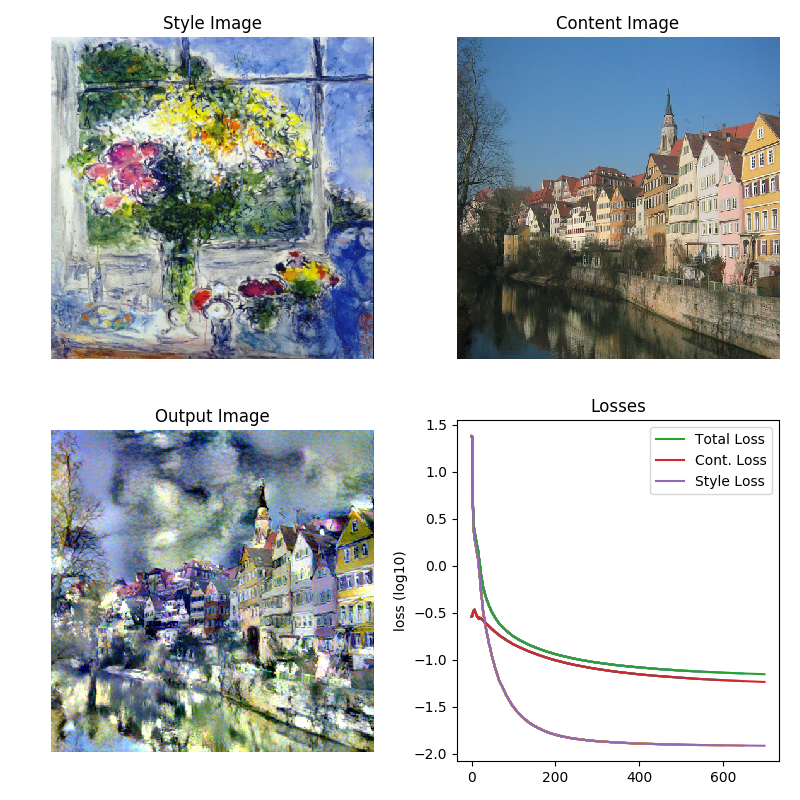

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [0]:
a = wikiart[124][0].to(device) # style image
p = testImages[0][0].to(device) # style image
optimize(optIm,a,p,700)

<IPython.core.display.Javascript object>


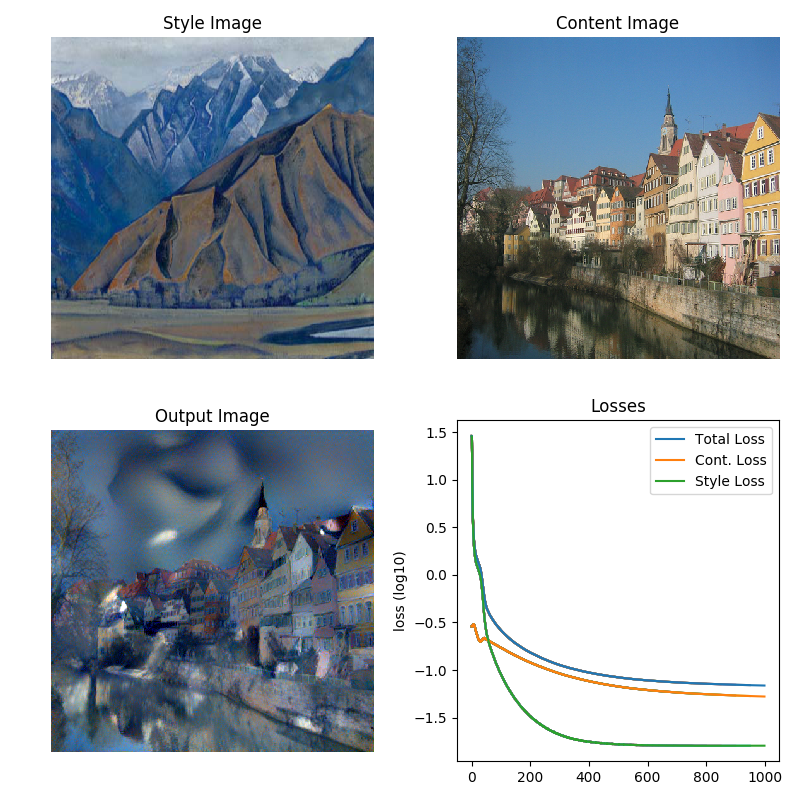

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [0]:
a = wikiart[147][0].to(device) # style image
p = testImages[0][0].to(device) # style image
optimize(optIm,a,p,1000)

<IPython.core.display.Javascript object>


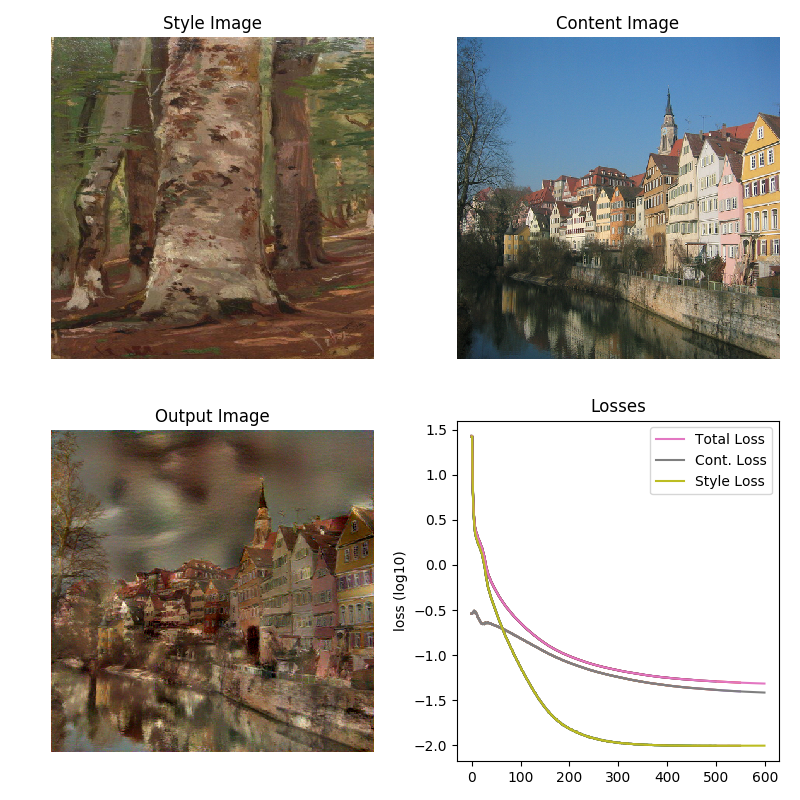

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [0]:
a = wikiart[152][0].to(device) # style image
p = testImages[0][0].to(device) # style image
optimize(optIm,a,p,1000)